In [1]:
# Import Dataset, joint model and pytorch train helpers
import transformers
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import sys
import torch.optim as optim
import torch
from TweetClassifier.distilbert_sequence_classifier import TweetBERT
from dataset_parser.waseem_parser import WaseemDataset
from joint_model import JointModel
from util.WeightedRandomSampler import WeightedRandomSampler

In [2]:
# Open data set and split in rain and dev and instantiate data loaders
# TODO: Fix split, currently the data split is different from the one used to pretrain BERT
#       -> data leakage from train to dev
trainset, devset, testset = WaseemDataset(fixed_set="train"), WaseemDataset(fixed_set="val"), WaseemDataset(fixed_set = "test")


Loading Waseem train set from fixed split.
Successfully loaded waseem dataset.
Loading Waseem val set from fixed split.
Successfully loaded waseem dataset.
Loading Waseem test set from fixed split.
Successfully loaded waseem dataset.


In [3]:
BATCH_SIZE = 128
sampler_trainset = WeightedRandomSampler(trainset, 1000)
sampler_devset = WeightedRandomSampler(devset, 1000)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                        num_workers=6, sampler = sampler_trainset)
devloader = torch.utils.data.DataLoader(devset, batch_size=1,
                                        num_workers=6)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                        num_workers=6)

In [4]:
# Instantiate joint model
# TODO: add edge_index lookup in SAGE submodel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
joint_model = JointModel(random_subset_size=None, dataset="waseem")
joint_model.to(device)
# load weights from trained model

Successfully initialized TweetNetwork submodel
Successfully initialized TweetClassifier submodel
neither done
racism done
sexism done
Successfully initialized TweetHistory submodel
Successfully initialized last final classification layer


JointModel(
  (SAGE): GraphSAGE(
    (model): SAGE(
      (convs): ModuleList(
        (0): SAGEConv(2, 32)
        (1): SAGEConv(32, 32)
        (2): SAGEConv(32, 32)
      )
    )
  )
  (BERT): TweetBERT(
    (model): DistilBertForSequenceClassification(
      (distilbert): DistilBertModel(
        (embeddings): Embeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (transformer): Transformer(
          (layer): ModuleList(
            (0): TransformerBlock(
              (attention): MultiHeadSelfAttention(
                (dropout): Dropout(p=0.1, inplace=False)
                (q_lin): Linear(in_features=768, out_features=768, bias=True)
                (k_lin): Linear(in_features=768, out_features=768, bias=True)
                (v_lin): Linear(in_features=768, 

In [5]:
if device == "cuda":
    print("check-if")
    #pass
    joint_model.load_state_dict(torch.load('../../models/joint_model_waseem_nulled_network_10epochs.model'))
else:
    print("check-else")
    joint_model.load_state_dict(torch.load('../../models/joint_model_waseem_nulled_network_10epochs.model', map_location=torch.device('cpu')))

check-else


In [16]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(joint_model.parameters(), lr=0.001)

In [13]:
# train joint model
print ("Batch size: {}".format(BATCH_SIZE))
for epoch in range(10):
    #break
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        input_ids, attention_mask, user_id, tweet_label = data['input_ids'], data['attention_mask'], data['userid'], data['label'] #TODO fix this mess
        input_ids, attention_mask, tweet_label = input_ids.to(device),  attention_mask.to(device), tweet_label.to(device)
        predictions = joint_model(input_ids,attention_mask, user_id)
        loss = criterion(predictions, tweet_label)
        loss.backward()
        running_loss += loss
        #if i % 64 == 0:
        optimizer.step()
        optimizer.zero_grad()
        if i % 4 == 0:
            print ("Epoch {}: {} tweets processed".format(epoch, i*BATCH_SIZE))
torch.save(joint_model.state_dict(), "../../models/joint_model_waseem_nulled_network_10epochs.model")

Batch size: 128
Epoch 0: 0 tweets processed
Epoch 0: 512 tweets processed
Epoch 0: 1024 tweets processed
Epoch 0: 1536 tweets processed
Epoch 0: 2048 tweets processed
Epoch 0: 2560 tweets processed
Epoch 1: 0 tweets processed
Epoch 1: 512 tweets processed
Epoch 1: 1024 tweets processed
Epoch 1: 1536 tweets processed
Epoch 1: 2048 tweets processed
Epoch 1: 2560 tweets processed
Epoch 2: 0 tweets processed
Epoch 2: 512 tweets processed
Epoch 2: 1024 tweets processed
Epoch 2: 1536 tweets processed
Epoch 2: 2048 tweets processed
Epoch 2: 2560 tweets processed
Epoch 3: 0 tweets processed
Epoch 3: 512 tweets processed
Epoch 3: 1024 tweets processed
Epoch 3: 1536 tweets processed
Epoch 3: 2048 tweets processed
Epoch 3: 2560 tweets processed
Epoch 4: 0 tweets processed
Epoch 4: 512 tweets processed
Epoch 4: 1024 tweets processed
Epoch 4: 1536 tweets processed
Epoch 4: 2048 tweets processed
Epoch 4: 2560 tweets processed
Epoch 5: 0 tweets processed
Epoch 5: 512 tweets processed
Epoch 5: 1024 tw

In [24]:
y_pred, y_true = [],[]
output_for_print = []
for i, data in enumerate(devloader):
    if i == 1:
        break
    if i%500 == 0:
        print(i)
    joint_model.eval()
    input_ids, attention_mask, user_id, tweet_label = data['input_ids'], data['attention_mask'], data['userid'], data['label'] #TODO fix this mess
    input_ids, attention_mask, tweet_label = input_ids.to(device),  attention_mask.to(device), tweet_label.to(device)
    predictions = joint_model(input_ids,attention_mask, user_id)
    predictions = torch.nn.functional.softmax(predictions)
    max_pred = torch.argmax(predictions)
    y_pred.append(max_pred.item())
    y_true.append(tweet_label.item())
    output_for_print.append([i,user_id.item(),tweet_label.item(),max_pred.item()])

0


Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [25]:
input_ids

tensor([[  101,  2061,  2852, 19895,  2080,  2074,  2056,  2002,  2001,  7622,
          1996,  3057, 12984,  2431,  1037,  7975,  1012,  1012,  2027, 12984,
          1037,  2878,  2028,  1001, 12395,  2099,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0]])

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
print (confusion_matrix(y_true=y_true, y_pred=y_pred))
print (classification_report(y_true=y_true, y_pred=y_pred))

[[ 518    2  179]
 [   1  255  129]
 [ 128   55 2157]]
              precision    recall  f1-score   support

           0       0.80      0.74      0.77       699
           1       0.82      0.66      0.73       385
           2       0.88      0.92      0.90      2340

    accuracy                           0.86      3424
   macro avg       0.83      0.78      0.80      3424
weighted avg       0.85      0.86      0.85      3424



In [ ]:
test_y_pred, test_y_true = [],[]
output_for_print = []
for i, data in enumerate(testloader):
    joint_model.eval()
    input_ids, attention_mask, user_id, tweet_label = data['input_ids'], data['attention_mask'], data['userid'], data['label'] #TODO fix this mess
    input_ids, attention_mask, tweet_label = input_ids.to(device),  attention_mask.to(device), tweet_label.to(device)
    test_predictions = joint_model(input_ids,attention_mask, user_id)
    test_predictions = torch.nn.functional.softmax(test_predictions)
    test_max_pred = torch.argmax(test_predictions)
    test_y_pred.append(test_max_pred.item())
    test_y_true.append(tweet_label.item())
    output_for_print.append([i,user_id.item(),tweet_label.item(),test_max_pred.item()])

In [ ]:
print (confusion_matrix(y_true=test_y_true, y_pred=test_y_pred))
print (classification_report(y_true=test_y_true, y_pred=test_y_pred))

In [14]:
y_true.count(2)

2340

# SHAP computations with class ShapExplainer

In [10]:
from SHAP.shap import ShapExplainer

In [11]:
# Shapley configuration
tweet_as_one = True 
vocab_as_one=False
network_as_one = True
untokenize = True
dataset = 'waseem'



In [26]:
for i, data in enumerate(devloader):
    #if i < 1:
    #    continue
    input_ids, attention_mask, user_id, tweet_label = data['input_ids'], data['attention_mask'], data['userid'], data['label']
    input_ids, attention_mask, tweet_label = input_ids.to(device),  attention_mask.to(device), tweet_label.to(device)
    if i == 1:
        break

In [27]:
input_ids 

tensor([[  101,  1030, 22712, 14526,  2683,  3956,  2003,  2069,  2667,  2000,
          6985,  2993,  2114, 25303,  7486,  2667,  2000, 13387,  2009,  2041,
          1012,  4895,  4494,  2011,  5152,  3741,  2812,  2498,  1012,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0]])

In [28]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
res = tokenizer.convert_ids_to_tokens(input_ids[0], skip_special_tokens = True)

res = tokenizer.convert_tokens_to_string(res)
print(res)

@ remy119 israel is only trying to defend itself against murderous muslims trying to wipe it out . un votes by muslim nations mean nothing .


In [51]:
model_explainer = ShapExplainer(joint_model, tweet_label = tweet_label.item(), tweet_as_one = tweet_as_one, vocab_as_one=vocab_as_one, network_as_one = network_as_one, dataset = dataset, untokenize = untokenize)


In [52]:
shapley_values, predicted_class, feature_distribution, vocab_indices = model_explainer.approximate_shap_values(input_ids, attention_mask, user_id)


Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [47]:
shapley_values, predicted_class, feature_distribution, vocab_indices

(tensor([[-0.1740, -0.0666,  0.0000],
         [ 0.5508, -0.2074,  0.0000],
         [-0.3768,  0.2740,  0.0000]], grad_fn=<PermuteBackward>),
 1,
 [1, 1, 1],
 None)

Original tweet: @ remy119 israel is only trying to defend itself against murderous muslims trying to wipe it out . un votes by muslim nations mean nothing .
Features contributions to class 1 (real class: 1)
3 3


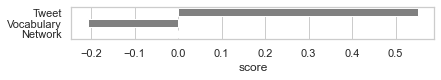

In [49]:
model_explainer.visualize_shap_values(input_ids, user_id, tweet_label, shapley_values[predicted_class], predicted_class, feature_distribution, vocab_indices)



In [33]:
model_explainer.visualize_text_plot(shapley_values[predicted_class],input_ids)

In [35]:
community_dictionary = torch.load('../../data/waseem/community_dictionary_user_Waseem.pt')

In [40]:
community_dictionary["2941145694"]['communities'] !=[]

False

In [36]:
user_id

tensor([2941145694])

# Code for computing the impact of each component

In [6]:
from SHAP.shap import ShapExplainer

In [31]:
# Shapley configuration
tweet_as_one = True
vocab_as_one=True
network_as_one = False
untokenize = True
dataset = 'waseem'

tokenizer_d = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [32]:
model_explainer = ShapExplainer(joint_model, tweet_as_one = tweet_as_one, vocab_as_one=vocab_as_one, network_as_one = network_as_one, dataset = dataset, untokenize = untokenize)


In [38]:
test_y_pred, test_y_true = [],[]
shap_output = []
for i, data in enumerate(testloader):
    if i != 470:
        continue
    print (data)
    joint_model.eval()
    input_ids, attention_mask, user_id, tweet_label = data['input_ids'], data['attention_mask'], data['userid'], data['label'] #TODO fix this mess
    input_ids, attention_mask, tweet_label = input_ids.to(device),  attention_mask.to(device), tweet_label.to(device)
    test_predictions = joint_model(input_ids,attention_mask, user_id)
    test_predictions = torch.nn.functional.softmax(test_predictions)
    test_max_pred = torch.argmax(test_predictions)
    shapley_values, predicted_class, feature_distribution, vocab_indices = model_explainer.approximate_shap_values(input_ids, attention_mask, user_id)
    res = tokenizer_d.convert_ids_to_tokens(input_ids[0], skip_special_tokens = True)
    res = tokenizer_d.convert_tokens_to_string(res)
    tweet_hate = shapley_values[0,0].item()
    tweet_offen = shapley_values[1,0].item()
    tweet_none = shapley_values[2,0].item()
    vocab_hate = shapley_values[0,1].item()
    vocab_offen = shapley_values[1,1].item()
    vocab_none = shapley_values[2,1].item()
    network_hate = shapley_values[0,2].item()
    network_offen = shapley_values[1,2].item()
    network_none = shapley_values[2,2].item()
    tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    res = tokenizer.convert_ids_to_tokens(input_ids[0], skip_special_tokens = True)

    res = tokenizer.convert_tokens_to_string(res)
    print(res)
    tweet_hate,tweet_offen,tweet_none,vocab_hate,vocab_offen,vocab_none,network_hate,network_offen,network_none
    
    shap_output.append([i,user_id.item(),shapley_values,test_max_pred])
    #model_explainer.visualize_text_plot(shap_values=shapley_values, input_ids=input_ids)
    
    if i % 250 == 0:
        print(i)

{'input_ids': tensor([[  101, 10645,  2003, 18101,  3892,  1012,  2298,  2041,  1010,  2016,
          1005,  1055,  1037,  7143,  2450,   999,  1001, 12395,  2099,  1001,
         12395,  2099, 11387, 16068,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'label': tensor([0]), 'userid': tensor([39015714])}
kat is ruthless tonight . look out , she ' s a desperate woman ! # mkr # mkr2015


Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [35]:
#[i,user_id.item(),shapley_values, res, test_max_pred]]
model_explainer.plot_network(shap_output)

{210: {'group': 0, 'direct_relation': 2, 'value': 293, 'label': '210, 2/2', 'color': '#fe004d'}, 1: {'group': 1, 'direct_relation': 1, 'value': 368, 'label': '1, 1/1', 'color': '#fe004d'}}


In [15]:
import pandas as pd
pd.DataFrame(shap_output).to_excel('Feature_Impact_Data_Waseem.xls')